# CCSNe GW Simple Model


In [48]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 16 23:12:07 2021
@author: cesartiznado
"""
import numpy as np
import random as rn 
from matplotlib import pyplot as plt
import scipy.signal as sg
import pandas as pd
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec


# =============================================================================


# =================== Inicial variables

def cond(Fm,t_ini,t_end,f_0,f_1,t_2,f_driver,Q,seed,OG):
    """
    Fm: Frecuencia de muestreo, t_ini:Tiempo inicial, t_end:Tiempo final
    f_0,f_1,t_2,f_driver,Q,ran_seed
    """
    dt = 1/Fm
    N  = np.arange(t_ini,t_end,dt) 
    n  = int(f_driver/(t_end-t_ini))
    t_n = np.random.uniform(t_ini,t_end,n) #Set the uniform distribution of t_n
    t_n = np.sort(t_n)       # t_n in progresive order
    t_s = np.arange(t_ini,t_end,dt) #Time in the inicial interval (simple)
    rn.seed(seed)
    f = np.zeros(len(t_s))    # Set memory to get the frequency
    p_2 = np.zeros(len(t_s))  # Set memory to p_2
    w = np.zeros(len(t_s))    # Set memory to angular frequency
    
    for i in range(0,len(t_s)):
        p_1    =  f_1 - f_0
        p_3    =  t_2 - t_ini
        ab     = (2*t_2-t_ini-1)*(1-t_ini)
        p_2[i] = t_s[i]-t_ini
        f[i] = f_0 + 2*p_1*p_3*(p_2[i])/(ab) - p_1*(p_2[i])**2/(ab)
        w[i] = 2*np.pi*f[i]
    
    return Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG

In [49]:
# =================== Delta implementation

def delta_imp():
    a_n1 = np.random.uniform(-1,1,n) 
    a_n1 =a_n1 *t_n
    a = np.zeros((len(t_s)))
    for i in range(0,len(t_s)):
        for j in range(0,n):
            #s[i,j] =  t_s[i]-t_n[j]
            #a[i] = np.minimum(s[i,:])
            if t_s[i]-t_n[j]<=0 and t_s[i]-t_n[j]>=-15e-6 :     
                #print("-")
                a[i] = a_n1[j]
                i+=1
    return a,a_n1

In [50]:
# ============== Model Implementation

def model(): 
    h_t = np.zeros(len(t_s))
    h = np.zeros(len(t_s))
    def F(a,h_t,h,w):
        return a - (w/Q)*h_t - (w**2)*h
    for i in range(0,len(t_s)):
        h_t[i] = h_t[i-1] + F(a[i-1],h_t[i-1],h[i-1],w[i-1])*dt
        h[i] = h[i-1] + h_t[i-1]*dt
    hrms = 1e-9
    h = h/hrms
    h = h/max(abs(h))
    return h


In [51]:
# ========================== Resample to 16386

sample = 16386
def sn_resample_wave(t,h,fs):
    """
    Interpolate array h to the fs sampling frequency.
   
    Input:
        t  - time array, in seconds
        h  - strain array to be interpolated
        fs - thi is the new sampling frequency
    Output:
        t1 - time array, after resampling
        h1 - new strain array
    """
   
    # Quick check
    if len(t)!=len(h):
        print("Error: t and h need to have equal sizes")
        return 0
   
    # Define new time with fs
    t1 = np.arange(t[0],t[-1],1.0/fs)
   
    # Interpolation
    tck = interpolate.splrep(t,h,s=0)
    h1  = interpolate.splev(t1,tck,der=0)
   
    return t1, h1

In [52]:
# ================ Add zeros to the angular frequeny,frequency, the signal and time
def pad_zeros():
    tleft = np.arange(-.5,t_ini,dt)
    tright = np.arange(t_end,1.5,dt)
    r = np.append(t_s,tright)
    tz = np.insert(r,0,tleft)
    
    hsr = np.zeros(len(tright))
    hsl = np.zeros(len(tleft))
    r3  = np.append(h,hsr)
    hz  = np.insert(r3,0,hsl)
    
    wr = np.zeros(len(tright))
    wl = np.zeros(len(tleft))
    r1 = np.append(w,wr)
    wz  = np.insert(r1,0,wl) 
    
    fr = np.zeros(len(tright))
    fl = np.zeros(len(tleft))
    r2 = np.append(f,fr)
    fz  = np.insert(r2,0,fl)
    return tz,wz,fz,hz

In [53]:
wnd="hamming"
nfft=4*4096
nperseg=4096
noverlap=4096-512

# =============================================================================
# Inicial Conditions of our Perturbartion
# =============================================================================
# =============== OG_1
#Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,1100,.6,600,10,8,1)

# =============== OG_2
#Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.2,100,400,.4,100,1,8,2)

# =============== OG_3
#Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.8,100,700,1.25,200,10,8,3)

# =============== OG_4

Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.2,0.9,300,1400,1.2,400,10,8,4)

# =============== OG_5
#Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.1,0.6,150,800,.8,250,1,8,5)


In [54]:
# =============================================================================
# Call de functions to execute the instructions
# =============================================================================

a,a_n1  = delta_imp()
h = model()
tz,wz,fz,hz = pad_zeros()
t1,h1 = sn_resample_wave(tz,hz,sample)

# ===================== Spectrogram
fxz, txz, Sxz = sg.spectrogram(hz, Fm, window=wnd, nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')
txz = txz + tz[0] # Recorrer el espectrograma



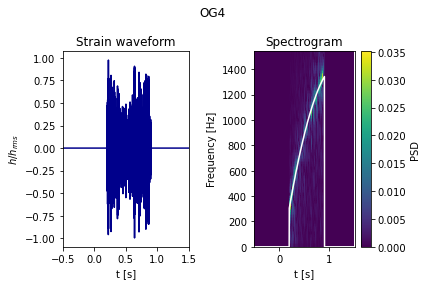

In [55]:
# =============================================================================
# Plots
# =============================================================================
# plt.figure()
# plt.pcolormesh(txz, fxz, Sxz,shading="auto")
# plt.plot(tz,fz,"r")
# plt.title("Spectrogram of the signal ")
# cbar = plt.colorbar()
# cbar.set_label('Amplitude strain [1/Hz]')
# plt.ylim([0,max(fz) +200])
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [s]')
# plt.tight_layout()
# plt.savefig("Spec_OG_4.png",pad_inches=20,dpi=400)
# plt.show()




# plt.plot(t1,h1,"black")
# plt.title("String") # Sample at 16386Hz
# plt.xlim(-0.5,1.0)
# plt.xlabel("t [s]")
# plt.ylabel("h/$h_{rms}$")
# plt.grid()
# plt.savefig("Strain_OG_4.png",pad_inches=20,dpi=400)
# plt.show()

# Save subplots
fig = plt.figure()
gs = gridspec.GridSpec(1,2,figure=fig)
fig.suptitle("OG4")
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(t1,h1,color="darkblue")
ax1.set_xlabel("t [s]")
ax1.set_ylabel("$h/h_{rms}$")
ax1.set_xlim(-.5,1.5)
ax1.set_title("Strain waveform")
ax2 = fig.add_subplot(gs[0,1])
ax2.set_ylim(0,max(fz) + 200)
ax2.set_xlim(-.5,1.5)
ax2.set_xlabel("t [s]")
ax2.set_ylabel("Frequency [Hz]")
ax2.plot(tz,fz,"w")
ax2.set_title("Spectrogram")
im1=ax2.pcolormesh(txz, fxz, Sxz,shading="auto")
cbar = plt.colorbar(im1, ax=ax2)
cbar.set_label("PSD")
fig.tight_layout()
fig.savefig("OG4.png",dpi=400,pad_inches=20)



In [56]:
# =============================================================================
# CSV exportation
# =============================================================================

# ========================== Data frame to export
datog1 = pd.DataFrame()
# Number = print(OG)

def save(datog):
    datog = pd.DataFrame()
    datog["Time"] = tz
    datog["Frequency"] = fz
    datog["Signal"] = hz
    return datog.to_csv("Datog4.csv",header=True,index = False)
    
# Call the function to make the csv file
save(datog1)

In [57]:
# =================== Logaritmical representation
# def log():
#     Sxxlog = np.log(Sxz) 
#     return Sxxlog
# Sxxlog = log()
# plt.figure()
# plt.pcolormesh(txz, fxz, Sxxlog,shading="auto")
# plt.plot(tz,fz,"r")
# plt.title("Frequency of the harmonic oscillator (Simple)")
# cbar = plt.colorbar()
# cbar.set_label('Amplitude strain [1/Hz]')
# plt.ylim([0,2000])
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [s]')
# plt.tight_layout()
# plt.show()